# Modelos pré-treinados

Um modelo pré-treinado (*pretrained model*) é aquele que foi previamente treinado e que contém os parâmetros (pesos e vieses) que representam as características (*features*) do conjunto de dados em que foi treinado. Contudo, algumas dessas características aprendidas são transferíveis, no sentido de que podem ser reaproveitadas para resolver tarefas sobre outros conjuntos de dados. Por exemplo, um modelo treinado em um grande conjunto de dados de imagens de pássaros conterá características aprendidas, como bordas ou linhas horizontais, que seriam transferíveis para o contexto de outros conjunto de dados em que essas características fossem relevantes.

Ao usar um modelo pré-treinado aproveitamos o conhecimento, além do tempo e recursos computacionais dispensados.

O portal [Model Zoo](https://modelzoo.co) mantém uma lista com modelos pré-treinados.

> "Model Zoo curates and provides a platform for deep learning researchers to easily find pre-trained models for a variety of platforms and uses. We regularly update the site, and provide filtering functionality for users to find models that they need, either for educational purposes, transfer learning, or other uses."

# Aprendizado por Tranferência (Transfer Learning) 

Definição da [Wikipedia](https://en.wikipedia.org/wiki/Transfer_learning):
> Transfer learning (TL) is a research problem in machine learning (ML) that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem.[1] For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks. 

A imagem a seguir ([fonte](https://www.researchgate.net/publication/342400905_Real-Time_Assembly_Operation_Recognition_with_Fog_Computing_and_Transfer_Learning_for_Human-Centered_Intelligent_Manufacturing/figures?lo=1)) ilustra o processo de aprendizado por transferência.

<center><img src='https://i.imgur.com/ZemddJ9.jpg'></center>


# Demo

Nesta seção, vamos usar um modelo pré-treinado, o Resnet34, construir um modelo de classificação de imagens por meio do aprendizado por tranferência.

Sobre a Resnet34 ([fonte](https://models.roboflow.com/classification/resnet34)):
> Resnet34 is a 34 layer convolutional neural network that can be utilized as a state-of-the-art image classification model. This is a model that has been pre-trained on the ImageNet dataset--a dataset that has 100,000+ images across 200 different classes.


## Download do conjunto de dados

Usaremos o conjunto de dados Oxford-IIIT Pets de https://course.fast.ai/datasets. É um conjunto de dados de imagens animais de estimação de 37 classe (raças) com cerca de 200 imagens para cada classe. As imagens têm uma grande variação de escala, pose e iluminação.

<center><img src='https://assets.website-files.com/60fe5405b57fd5b91421b132/611210d3a9345818446be89b_5f338333d940ef70690a4d17_5f30c0cd064e01650e39a857_oxford-p-1080.png'></center>

In [ ]:
from torchvision.datasets.utils import download_url

In [ ]:
download_url('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', '.')

  0%|          | 0/811706944 [00:00<?, ?it/s]

In [ ]:
import tarfile

with tarfile.open('./oxford-iiit-pet.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
from torch.utils.data import Dataset

In [ ]:
import os

DATA_DIR = './data/oxford-iiit-pet/images'

files = os.listdir(DATA_DIR)
files[:5]

['samoyed_160.jpg',
 'shiba_inu_37.jpg',
 'Egyptian_Mau_9.jpg',
 'Birman_63.jpg',
 'great_pyrenees_72.jpg']

In [ ]:
def parse_breed(fname):
    parts = fname.split('_')
    return ' '.join(parts[:-1])

In [ ]:
parse_breed(files[4])

'great pyrenees'

In [ ]:
from PIL import Image

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

## Criação de um objeto Dataset customizado

In [ ]:
import os

class PetsDataset(Dataset):
    def __init__(self, root, transform):
        super().__init__()
        self.root = root
        self.files = [fname for fname in os.listdir(root) if fname.endswith('.jpg')]
        self.classes = list(set(parse_breed(fname) for fname in files))
        self.transform = transform
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        fpath = os.path.join(self.root, fname)
        img = self.transform(open_image(fpath))
        class_idx = self.classes.index(parse_breed(fname))
        return img, class_idx

In [ ]:
import torchvision.transforms as T

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset = PetsDataset(DATA_DIR, T.Compose([T.Resize(img_size), 
                                           T.Pad(8, padding_mode='reflect'),
                                           T.RandomCrop(img_size), 
                                           T.ToTensor(), 
                                           T.Normalize(*imagenet_stats)]))

In [ ]:
len(dataset)

7390

In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label: Egyptian Mau (33)


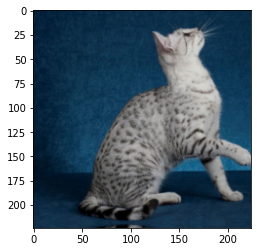

In [ ]:
show_image(*dataset[2])

## Criação dos conjuntos de treino e validação

In [ ]:
from torch.utils.data import random_split

In [ ]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))

train_ds, valid_ds = random_split(dataset, [len(dataset) - val_size, val_size])

In [ ]:
from torch.utils.data import DataLoader
batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break


In [ ]:
show_batch(train_dl)

Output hidden; open in https://colab.research.google.com to view.

## Construção do modelo

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))


A célula de código a seguir define a classe do modelo. Repare a chamada à função `models.resnet34` que retorna o modelo pré-treinado ResNet34.

Repare também que o código abaixo realizar a substituição da última camada do modelo pré-treinado.

In [ ]:
from torchvision import models

class PetsModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

## Treinamento com transferência 

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

### Refinamento do modelo pré-treinado (ResNet34)

In [ ]:
model = PetsModel(len(dataset.classes))
to_device(model, device);

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.02493460848927498, 'val_loss': 3.7913942337036133}]

In [ ]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0],last_lr: 0.00589, train_loss: 1.3388, val_loss: 84.7324, val_acc: 0.0201


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00994, train_loss: 2.0201, val_loss: 3.9083, val_acc: 0.0797


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00812, train_loss: 1.2448, val_loss: 1.8524, val_acc: 0.5052


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00463, train_loss: 0.8537, val_loss: 1.2736, val_acc: 0.6326


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00133, train_loss: 0.4919, val_loss: 0.7816, val_acc: 0.7595


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00000, train_loss: 0.3270, val_loss: 0.6147, val_acc: 0.8040
CPU times: user 57.4 s, sys: 47.4 s, total: 1min 44s
Wall time: 6min 28s


## Treinamento sem transferência

Para fins de comparação, vamos agora treinar um modelo de classificação sem realizar a tranferência dos parâmetros a partir do modelo ResNet34.

In [ ]:
model2 = PetsModel(len(dataset.classes), pretrained=False)
to_device(model2, device);

In [ ]:
history2 = [evaluate(model2, valid_dl)]
history2

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.035470299422740936, 'val_loss': 55.67347717285156}]

In [ ]:
%%time
history2 += fit_one_cycle(epochs, max_lr, model2, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0],last_lr: 0.00589, train_loss: 3.5743, val_loss: 488.7793, val_acc: 0.0379


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00994, train_loss: 3.4061, val_loss: 11.9655, val_acc: 0.0428


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00812, train_loss: 3.1441, val_loss: 3.4559, val_acc: 0.0900


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00463, train_loss: 2.8842, val_loss: 3.0299, val_acc: 0.1613


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00133, train_loss: 2.6478, val_loss: 3.0261, val_acc: 0.1640


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00000, train_loss: 2.4238, val_loss: 2.6726, val_acc: 0.2794
CPU times: user 58.4 s, sys: 49.7 s, total: 1min 48s
Wall time: 6min 29s


While the pretrained model reached an accuracy of 80% in less than 3 minutes, the model without pretrained weights could only reach an accuracy of 24%.